# Разработка стратегии взаимодействия с клиентами фитнес-центра

# Оглавление
1. [Описание проекта](#title)
2. [Загрузка данных и подготовка их к анализу](#load)
  * [Подключение библиотек](#import)
  * [Загрузка данных и получение общей информации](#info)
3. [Исследовательский анализ данных](#eda)
 - [Изучение общих характеристик датасета](#analysis_characteristics)
 - [Анализ средних значений признаков по группам ( тех, кто ушел в отток и тех, кто остался)](#analysis_mean)
 - [Анализ распределения признаков по группам](#analysis_groups)
 - [Матрица корелляции](#matrix)
4. [Модель прогнозирования оттока клиентов](#model_curn)
5. [Кластеризация клиентов](#clusters)
 - [Стандартизируем данные](#std)
 - [Матрица расстояний](#dendrogram)
 - [Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов](#KMeans)
 - [Распределение признаков для кластеров](#distr)
 - [Отток по кластерам](#churn)
6. [Общий вывод](#conclusion)

<a id="title"></a> 
## Описание проекта

Цель проекта: провести анализ и подготовить план действий по удержанию клиентов:
- Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- Проанализировать основные признаки, наиболее сильно влияющие на отток;
- Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
 + выделить целевые группы клиентов;
 + предложить меры по снижению оттока;
 + определить другие особенности взаимодействия с клиентами.

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент, в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

<a id="load"></a> 
## Загрузка данных и подготовка их к анализу

<a id="import"></a> 
### Подключение библиотек

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 



<a id="info"></a> 
### Загрузка данных и получение общей информации

In [59]:
data = pd.read_csv('/datasets/gym_churn.csv')

In [60]:
def inspect (df):
    display(df.sample(n = 5, random_state = 0)) #посмотрим случайные строки
    df.info() 
    print ('Количество полных дубликатов - ' + str(df.duplicated().sum()))

In [61]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
inspect(data)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
2230,0,1,1,1,1,12,1,29,260.51,12.00,2,2.35,2.32,0
668,0,0,0,0,1,1,1,27,48.09,1.00,0,1.00,0.73,1
3616,0,0,1,0,1,6,0,30,24.62,5.00,2,0.00,0.00,0
2363,1,1,0,0,1,1,1,27,139.89,1.00,0,2.32,1.84,1
142,1,0,1,0,0,12,0,29,89.66,12.00,1,3.52,3.37,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [62]:
# проверим на дубликаты без учета колонки id
data.duplicated(subset = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn']).sum()

0

In [63]:
# убираем прописные буквы в названиях
data.columns = [x.lower() for x in data.columns.values] 

Проверим все ли данные в колонке 'Month_to_end_contract' фактически целочисленные, если да, то переведем их в соотвествующий тип

In [64]:
data['month_to_end_contract'].value_counts()

1.00     2207
6.00      645
12.00     524
11.00     181
5.00      130
10.00      82
9.00       73
4.00       58
8.00       38
7.00       25
3.00       23
2.00       14
Name: month_to_end_contract, dtype: int64

In [65]:
#так и есть, переводим
data.month_to_end_contract = data.month_to_end_contract.astype(np.int64)

Вывод:
- пропуски и дубликаты в данных отсутствуют
- названия колонок и типы данных корректны (колонка month_to_end_contract переведена в целочисленному типу), возможно часть данных стоит привести к типу bool, определим это далеее
- в названиях прописные буквы испралены на строчные 

<a id="eda"></a>
## Анализ данных

<a id="analysis_characteristics"></a>
### Изучение общих характеристик датасета

In [66]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Как мы и видели при изучении общей информации - пропусков нет, есть колонки по которым среднее сильно отличается от медианы, далее посмотрим на гистограммах, возможно имеются выбросы.

Распределение данных по полу - практически поровну, в основном клиенты  проживают или работают в районе, где находится фитнес-центр, чуть менее половины - компании-партнёра клуба, в среднем 30% пришли по акции «приведи друга», большинство оставили контактные телефон (а с теми кто нет, и  при этом еще является действующим клиентом надо поработать и этот телефон заполучить), 50% имеют абонемент на месяц, однако в среднем абонемент берут на 4-5 месяцев вперед, есть даже те у кого  абонементы на год, меньше половины клиентов посещают групповые занятия, средний возраст клиентов - 29 лет, максимальные 41 (возможно стоит задуматься над расширением, группы для детей или пенсионеров), в среднем клиент приносит 136 единиц дохода, но здесь велико стандартное отклонение,  в среднем у клиентов еще по 4 месяца до окончания действия абонементов, при этом время с момента первого обращения в фитнес-центр - 3, в среднем клиенты посещают зал 2 раза в неделю, и фитнес зал теряет около 26% клиентов.

<a id="analysis_mean"></a>
### Анализ средних значений признаков по группам ( тех, кто ушел в отток и тех, кто остался)

Что бы понять какие именно клиенты, посмотрим какие их принаки отличаются от тех, что остались

In [67]:
group_by_churn = data.groupby('churn').agg('mean').T
group_by_churn.columns = ['stay', 'left']
group_by_churn['diff_%']=(1-group_by_churn['stay']/group_by_churn['left'])*100
group_by_churn

,stay,left,diff_%
gender,0.51,0.51,0.16
near_location,0.87,0.77,-13.66
partner,0.53,0.36,-50.34
promo_friends,0.35,0.18,-92.35
phone,0.90,0.90,-0.09
contract_period,5.75,1.73,-232.48
group_visits,0.46,0.27,-72.78
age,29.98,26.99,-11.07
avg_additional_charges_total,158.45,115.08,-37.68
month_to_end_contract,5.28,1.66,-217.76


Очевидно, что кроме пола и данных о контактном телефоне, остальные признаки значительно ниже у клиентов, которые ушли. Особенно сильно выделяются длительность абонемента, срок до окончания абонемента, время с момента первого обращения. Что логично, скорее уйдут те, кто купил краткосрочный абонемент. Кроме того, ушедшие пользователи были менее склонны к групповым занятиям, не пользовались дополнительными услугами, и в целом реже посещали фитнес центр, кроме того их активность снизилась в последний месяц, в отличии от тех, кто остался. Реже уходят сотрудники сотрудник компании-партнёра клуба и пришедшии в рамках акции, возраст ушедших клиентов так же несколько ниже.

<a id="analysis_groups"></a>
### Анализ распределения признаков по группам

Нарисуем гистограммы распределения признаков

In [68]:
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [69]:
bool_features = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
int_features = ['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

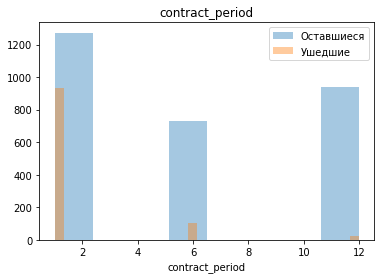

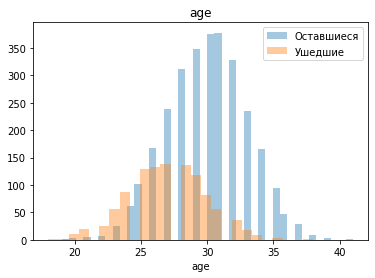

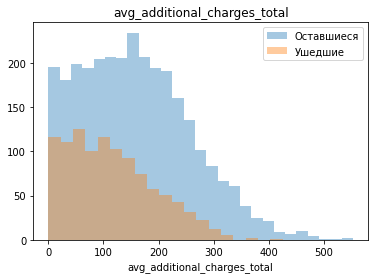

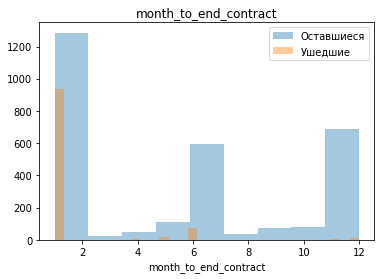

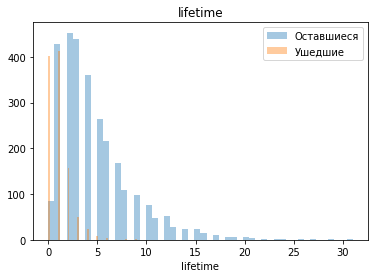

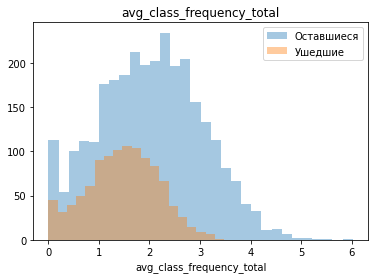

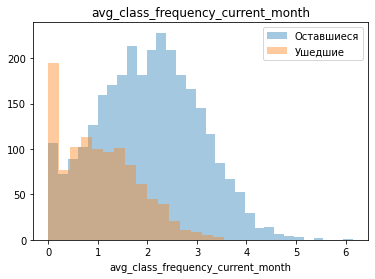

In [70]:
for feature in int_features:
    plt.title(feature)
    sns.distplot(data.query('churn==0')[feature], kde=False)
    sns.distplot(data.query('churn==1')[feature], kde=False)
    plt.legend(['Оставшиеся', 'Ушедшие'])
    plt.show() 

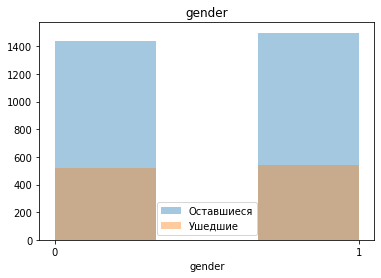

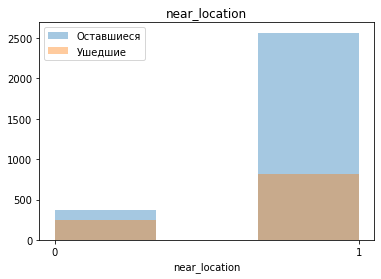

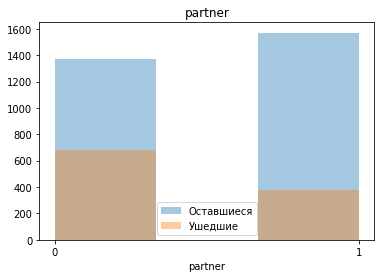

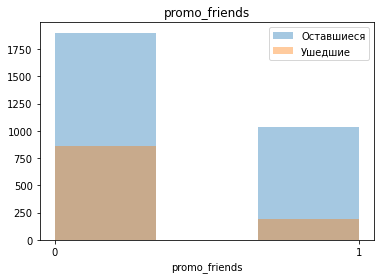

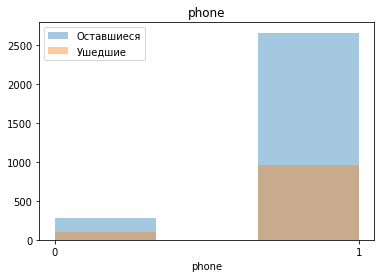

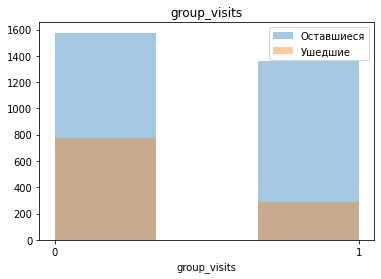

In [71]:
for feature in bool_features:
    plt.title(feature)
    ax=sns.distplot(data.query('churn==0')[feature], kde=False, bins = 3)
    ax=sns.distplot(data.query('churn==1')[feature], kde=False, bins = 3)
    plt.legend(['Оставшиеся', 'Ушедшие'])
    ax.set_xticks([0,1])
    plt.show() 

Гистограммы подтверждают сделанные ранее выводы о распределении ущедших и осташихся клиентов:
- распределение по полу примерно одинаково;
- чаще остаются те, кто живет или работает вблизи фитнес центра, те кто живут в отдалении, остаются и уходят приблизительно в одинаковом количестве
- сотрудники компании-партнёра клуба уходят реже (возможно из за скидок или доп.привелегий)
- чаще уходят клиенты, пришедшие самостоятельно, не в рамках акции, а также купившие абонементы на месяц, они же меньше посещают групповые занятия
- средний возраст оставшихся клиентов выше, возможно они более взвешенно принимают решения о начале занятий, или меньше склонные к переменам
- ушедшие клиенты менее склонны к приобретению дополнительных услуг, реже посещают фитнес зал

<a id="matrix"></a>
### Матрица корелляции

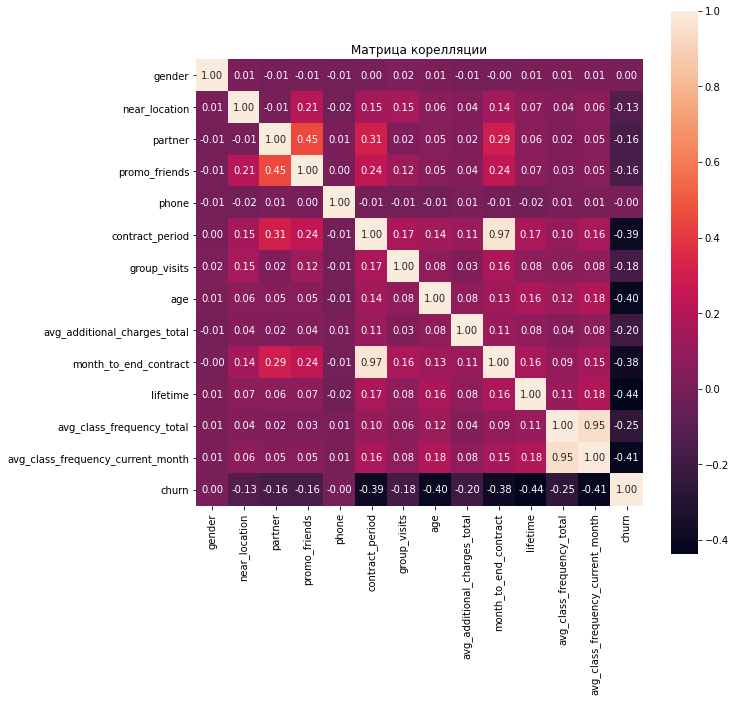

In [72]:
#построим и отрисуем матрицу корреляций
cm = data.corr()  #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(10,10))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True, fmt = '0.2f')
plt.title('Матрица корелляции')
plt.show()

Наиболее влияющие на отток признаки: срок абонемента, время с момента первого обращения, срок до окончания абонемента, средняя частота посещений в неделю за предыдущий месяц  и возраст. Однако даже их влияние низкое, можно говорить что линейная зависимость между оттоком и состальными признаками в отдельности отсутствует. 

Имеются скореллировавшие между собой признаки 'Contract_period' и 'Month_to_end_contract', а так же 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month'. В дальнейшем для если мы будем использовать модель линейной регрессии, число признаков нужно будет сократить

Выводы:
- распределение по полу тех кто ушел и остался  примерно одинаково;
- чаще остаются те, кто живет или работает вблизи фитнес центра, те кто живут в отдалении, остаются и уходят приблизительно в одинаковом количестве
- сотрудники компании-партнёра клуба уходят реже (возможно из за скидок или доп.привелегий)
- чаще уходят клиенты, пришедшие самостоятельно, не в рамках акции, а также купившие абонементы на месяц, они же меньше посещают групповые занятия
- средний возраст оставшихся клиентов выше, возможно они более взвешенно принимают решения о начале занятий, или меньше склонные к переменам
- ушедшие клиенты менее склонны к приобретению дополнительных услуг, реже посещают фитнес зал.
- нет отдельных признаков которые бы оказывали сильное линейное влиянние на отток
- имеются скореллировавшие между собой признаки 'Contract_period' и 'Month_to_end_contract', а так же 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month'

<a id="model_curn"></a>
## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [73]:
# Разобьем данные на обучающую и валидационную выборку 
X = data.drop('churn',  axis=1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# признаки следует привести к стандартному виду 
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

    
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [74]:
#Исключим сильно скоррелировавшие признаки
data_mod = data.drop(['month_to_end_contract', 'avg_class_frequency_total'],  axis=1)
# Разобьем данные на обучающую и валидационную выборку 
X = data_mod.drop('churn',  axis=1)
y = data_mod['churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# признаки следует привести к стандартному виду 
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

    
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82


In [75]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:, 1] 
# выведем все метрики
print_all_metrics(
    y_test, 
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75


Вывод: метрики обеих моделей примерно одинаковы, но но все же доля правильных ответов и полнота выше у модели логистической регрессии

<a id="clusters"></a>
## Кластеризация клиентов

<a id="std"></a>
### Стандартизируем данные

In [76]:
#возьмем данные без учета сильно скоррелированных признаков
scaler = StandardScaler() 
x_sc = scaler.fit_transform(data.drop(columns = ['churn']))

<a id="dendrogram"></a>
### Матрица расстояний

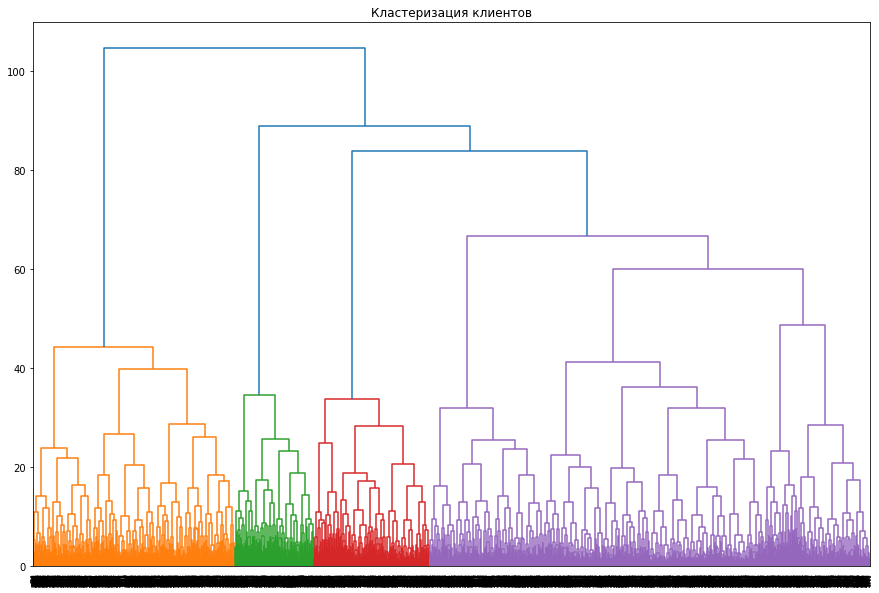

In [77]:
linked = linkage(x_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике

<a id="KMeans"></a>
### Обучение модели кластеризации на основании алгоритма K-Means и прогнозирование кластеров клиентов

In [78]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) 
# сохраняем метки кластера в поле нашего датасета
data['cluster'] = labels
# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


In [79]:
data['cluster'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

Итак мы имеем 5 кластеров

- "0" представители компаний - партнеров, большей частью пришедшие по акции "приведи друга", любят групповые занятия и приобретают абонементы на максимально длительный срок, приносят нам много выручки от других услуг фитнес-центра, практически не меняют чатоту посещений из месяца в месяц - это самые "стабильные" клиенты, их не большинство, но много и это радует
- "1" - единственные кто не осталяет телефонов "конспираторы", самая малочисленная группа, приходят в большинстве самоходом
- "2" - "одиночки", живут или работают далеко, не любят групповые занятия, пришли к нам самоходом
- "3" - самые "ненадежные", хоть до финтнес-центра и рукой подать, но посещают они его реже всех да и имеют склонность снижать частоту посещения со временем
- "4" - довольно близки к группе "0", взможно их стоит даже объединить, однако предпочитают более краткосрочные абонементы и чаще всех посещают фитнес-центр "увлеченные"

<a id="distr"></a>
### Распределение признаков для кластеров

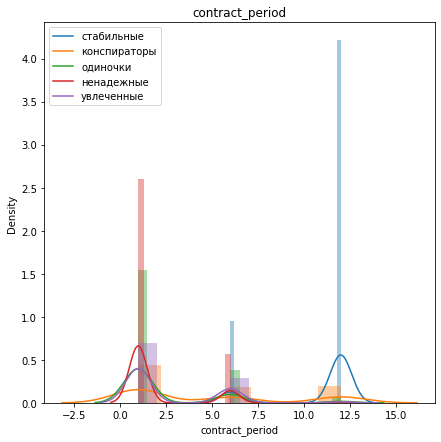

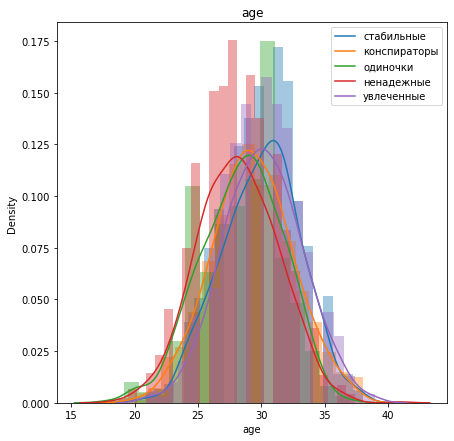

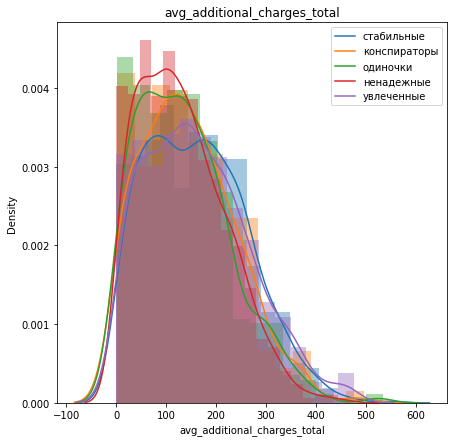

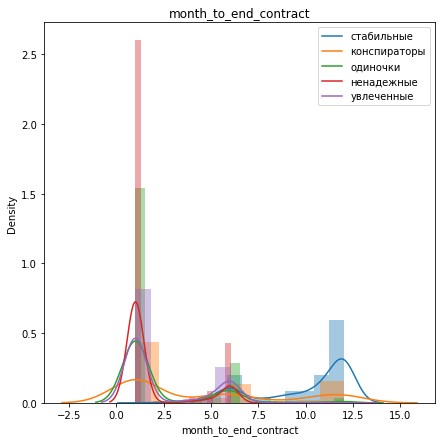

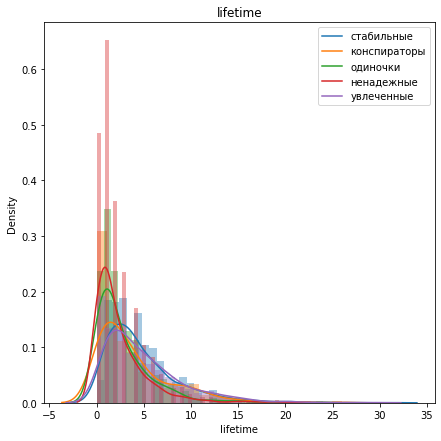

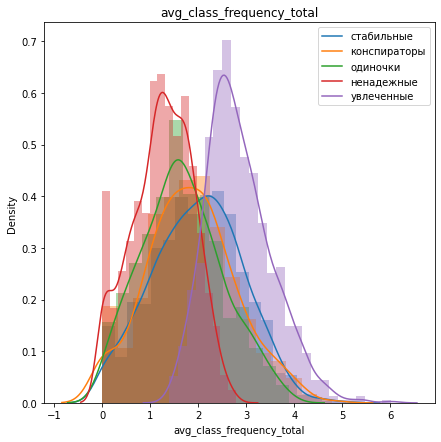

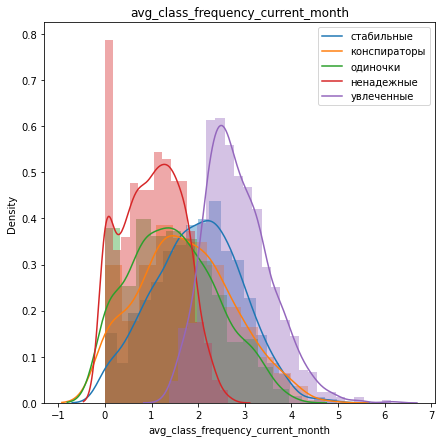

In [84]:

for feature in int_features:
    plt.figure(figsize=(7, 7))
    plt.title(feature)    
    sns.distplot(data.query('cluster==0')[feature])
    sns.distplot(data.query('cluster==1')[feature])
    sns.distplot(data.query('cluster==2')[feature])
    sns.distplot(data.query('cluster==3')[feature])
    sns.distplot(data.query('cluster==4')[feature])
     
    plt.legend(['стабильные', 'конспираторы', 'одиночки', 'ненадежные', 'увлеченные'])
    plt.show() 

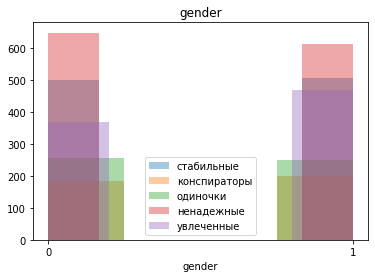

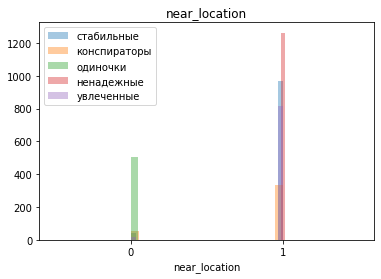

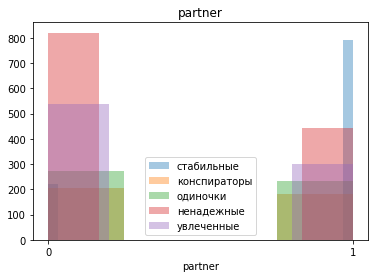

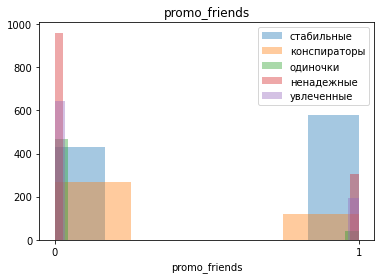

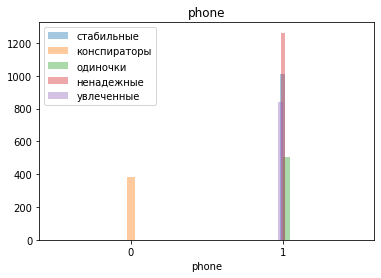

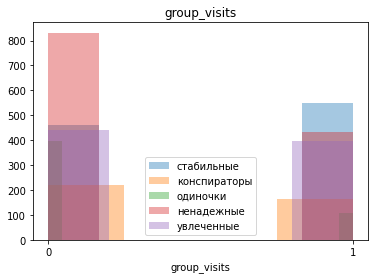

In [85]:
for feature in bool_features:
    plt.title(feature)
    ax=sns.distplot(data.query('cluster==0')[feature], kde=False)
    ax=sns.distplot(data.query('cluster==1')[feature], kde=False)
    ax=sns.distplot(data.query('cluster==2')[feature], kde=False)
    ax=sns.distplot(data.query('cluster==3')[feature], kde=False)  
    ax=sns.distplot(data.query('cluster==4')[feature], kde=False)
    plt.legend(['стабильные', 'конспираторы', 'одиночки', 'ненадежные', 'увлеченные'])
    ax.set_xticks([0,1])
    plt.show() 

Выводы

- 'Contract_period' — длительность текущего действующего абонемента. Стабильные клиенты чаще всего покупают абонементы на 12 месяцев, «ненадежные» и «одиночки» наоборот на 1 месяц «увлеченные» на чаще на 1 и реже на 6 месяцев, «конспираторы» чаще на 1, реже на 6 и 12 месяцев.
- 'Age' — Возраст: распределение по возрасту примерно одинаково, несколько старше «стабильные клиенты, младше – «ненадежные»
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента. Больше всего у «стабильных» что логично, они покупают абонементы на 12 месяцев, в целом этот признак коррелирует с 'Contract_period'
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц коррелируют между собой, одако можно сделать некоторый вывод о возможном оттоке из их динамики, % оттока выше у кластеров по которым данный показатель снижается, например у «конспираторов», «одиночек» и «ненадежных» клиентов
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра. Больше всего тратят «стабильные» и «увлеченные» группы клиентов
- 'gender' — пол: распределение равномерное
- Near_Location' Практически все клиенты, кроме «одиночек» проживают или работают в районе, где находится фитнес-центр
- 'Partner' — среди всех групп имеются сотрудники компании-партнёра клуба, больше таковых среди «стабильных клиентов», меньше среди «ненадежных»
- Promo_friends — Факт первоначальной записи в рамках акции «приведи друга» так же выше таковых среди «стабильных» клиентов, меньше среди «ненадежных»
- 'Phone' —Наличие контактного телефона – тут отличились только «конспираторы»
- 'Group_visits' - факт посещения групповых занятий так же выше среди «стабильных» клиентов, меньше среди «ненадежных»


<a id="churn"></a>
### Отток по кластерам

In [82]:
data.groupby('cluster')['churn'].mean().to_frame()

,churn
cluster,
0,0.03
1,0.27
2,0.44
3,0.51
4,0.07


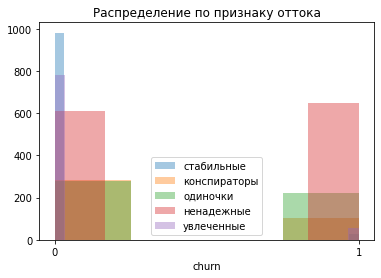

In [86]:
plt.title('Распределение по признаку оттока')
ax=sns.distplot(data.query('cluster==0')['churn'], kde=False)
ax=sns.distplot(data.query('cluster==1')['churn'], kde=False)
ax=sns.distplot(data.query('cluster==2')['churn'], kde=False)
ax=sns.distplot(data.query('cluster==3')['churn'], kde=False)  
ax=sns.distplot(data.query('cluster==4')['churn'], kde=False)
plt.legend(['стабильные', 'конспираторы', 'одиночки', 'ненадежные', 'увлеченные'])
ax.set_xticks([0,1])
plt.show()

Вывод : "Стабильные" и "увлеченные" наши самые лояльные клиенты, верояность невозврата "ненадежного" клиента больше 50%, "одиночки" так же склонны к оттоку, "конспираторы" где то по середине, возможно их можно уговорить вернуться, заполучив телефон

## Общий вывод

При предварительном исследовании данных определено:
- пропуски и дубликаты в данных отсутствуют
- названия колонок и типы данных корректны (колонка month_to_end_contract переведена в целочисленному типу)
- в названиях прописные буквы испралены на строчные 
По результатам анализа данных можно сделать выводы:
- распределение по полу примерно одинаково;
- чаще остаются те, кто живет или работает вблизи фитнес центра, те кто живут в отдалении, остаются и уходят приблизительно в одинаковом количестве
- сотрудники компании-партнёра клуба уходят реже (возможно из за скидок или доп.привелегий)
- чаще уходят клиенты, пришедшие самостоятельно, не в рамках акции, а также купившие абонементы на месяц, они же меньше посещают групповые занятия
- средний возраст оставшихся клиентов выше, возможно они более взвешенно принимают решения о начале занятий, или меньше склонные к переменам
- ушедшие клиенты менее склонны к приобретению дополнительных услуг, реже посещают фитнес зал

По матрице кореляции можно сказать что нет признаков однозначно влияющих (линейно) на отток, имеются скореллировавшие между собой признаки 'Contract_period' и 'Month_to_end_contract', а так же 'Avg_class_frequency_total' и 'Avg_class_frequency_current_month'
В качестве модели прогнозирования оттоков выбрана модель логистической регрессии (метрики обеих моделей примерно одинаковы, но но все же доля правильных ответов выше у модели логистической регрессии)

После разбиения на кластеры мы получили:
- "0" представители компаний - партнеров, большей частью пришедшие по акции "приведи друга", любят групповые занятия и приобретают абонементы на максимально длительный срок, приносят нам много выручки от других услуг фитнес-центра, практически не меняют чатоту посещений из месяца в месяц - это самые "стабильные" клиенты, их не большинство, но много и это радует
- "1" - единственные кто не осталяет телефонов "конспираторы", самая малочисленная группа, приходят в большинстве самоходом
- "2" - "одиночки", живут или работают далеко, однако, не любят групповые занятия, пришли к нам самоходом
- "3" - самые "ненадежные", хоть до финтнес-центра и рукой подать, но посещают они его реже всех да и имеют склонность снижать частоту посещения со временем
- "4" - довольно близки к группе "0", взможно их стоит даже объединить, однако предпочитают более краткосрочные абонементы и чаще всех посещают фитнес-центр "увлеченные"

Анализ признаков по кластерам дал следующий результат:
- 'Contract_period' — длительность текущего действующего абонемента. Стабильные клиенты чаще всего покупают абонементы на 12 месяцев, «ненадежные» и «одиночки» наоборот на 1 месяц «увлеченные» на чаще на 1 и реже на 6 месяцев, «конспираторы» чаще на 1, реже на 6 и 12 месяцев.
- 'Age' — Возраст: распределение по возрасту примерно одинаково, несколько старше «стабильные клиенты, младше – «ненадежные»
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента. Больше всего у «стабильных» что логично, они покупают абонементы на 12 месяцев, в целом этот признак коррелирует с 'Contract_period'
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц коррелируют между собой, одако можно сделать некоторый вывод о возможном оттоке из их динамики, % оттока выше у кластеров по которым данный показатель снижается, например у «конспираторов», «одиночек» и «ненадежных» клиентов
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра. Больше всего тратят «стабильные» и «увлеченные» группы клиентов
- 'gender' — пол: распределение равномерное
- Near_Location' Практически все клиенты, кроме «одиночек» проживают или работают в районе, где находится фитнес-центр
- 'Partner' — среди всех групп имеются сотрудники компании-партнёра клуба, больше таковых среди «стабильных клиентов», меньше среди «ненадежных»
- Promo_friends — Факт первоначальной записи в рамках акции «приведи друга» так же выше таковых среди «стабильных» клиентов, меньше среди «ненадежных»
- 'Phone' —Наличие контактного телефона – тут отличились только «конспираторы»
- 'Group_visits' - факт посещения групповых занятий так же выше среди «стабильных» клиентов, меньше среди «ненадежных»

Анализ показателя оттока по кластерам позволяет сделать вывод, что "Стабильные" и "увлеченные" наши самые лояльные клиенты, верояность невозврата "ненадежного" клиента больше 50%, "одиночки" так же склонны к оттоку, "конспираторы" где то по середине, возможно их можно уговорить вернуться, заполучив телефон

**Рекомендации**
- Стоит обратить внимание на одиночек, месторасположение для них похоже неудобное (далеко от дома или места работы), однако они все равно посещали фитнес- зал и приобретали не самые краткосрочные абонементы, однако частота их посещений со временем снижалась, и они редко посещали групповые занятия, возможно им не очень подходило расписание, возможно им стоит преложить индивидуальные занятия с инструктором
- Обязательно надо восполнить базу по телефонным номерам клиентов, возможно что бы вернуться не хватает простого телефонного звонка
- Совсем не охвачены услугами фитнес центра дети и клиентов старше 41 года, возможно для них стоит разработать какие то программы 
- "Ненадежных" клиентов стоит уговорить на более долгосрочные абонементы